In [2]:
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import re

<H1> Домашнее задание 1. </H1>
<H2> Задание 1</H2>

На основании данных рейтинга top500 спрогнозировать  производительность компьютера №1 в 2025

<H3> Парсинг данных </H3>

Данные берутся с сайта https://www.top500.org/statistics/perfdevel/.
Их можно получить лишь с помощью кода ниже


In [3]:
resp = requests.get('https://www.top500.org/statistics/perfdevel/')
soup = BeautifulSoup(resp.text, 'html')
raw_js = soup.find_all('script')[12].string

dates = re.findall('new Date\((.+?)\),\n', raw_js)
dates = [date.replace(', ', '-').replace('-5-1', '-05-01').replace('-10-1', '-10-01') for date in dates]

top1 = re.findall('#1\s=\s(.+?)\",\n', raw_js)
top1 = [float(s.replace(' GFlop/s', 'e0').replace(' TFlop/s', 'e3').replace(' PFlop/s', 'e6')) for s in top1]

top500 = re.findall('#500\s=\s(.+?)\"],', raw_js)
top500 = [float(s.replace(' GFlop/s', 'e0').replace(' TFlop/s', 'e3').replace(' PFlop/s', 'e6')) for s in top500]

topSum = re.findall('Sum\s=\s(.+?)\",\n', raw_js)
topSum = [float(s.replace(' GFlop/s', 'e0').replace(' TFlop/s', 'e3').replace(' PFlop/s', 'e6').replace(' EFlop/s', 'e9')) for s in topSum]

df = pd.DataFrame({'date': dates, 'top1': top1, 'top500': top500, 'sum': topSum})
df['date'] = df['date'].apply(pd.to_datetime)
# df.set_index(['top1', 'top500', 'sum'])
df.head()

,date,top1,top500,sum
0,1993-05-01,59.7,0.4,1100.0
1,1993-10-01,124.0,0.5,1500.0
2,1994-05-01,143.4,0.8,2300.0
3,1994-10-01,170.0,1.2,2700.0
4,1995-05-01,170.0,2.0,3900.0


<H3>Анализ данных</H3>

Text(0, 0.5, 'GFlop/s')

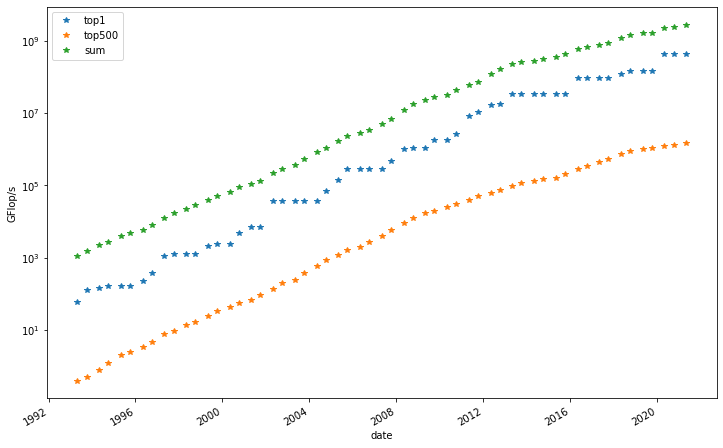

In [4]:
plt.figure(figsize=(12, 8))
ax = plt.subplot()
colors = ['blue', 'orange', 'red']
df.plot('date', ['top1', 'top500', 'sum'], ax=ax, logy=True, style='*')
ax.set_ylabel('GFlop/s')

<H3>Обучение модели </H3>

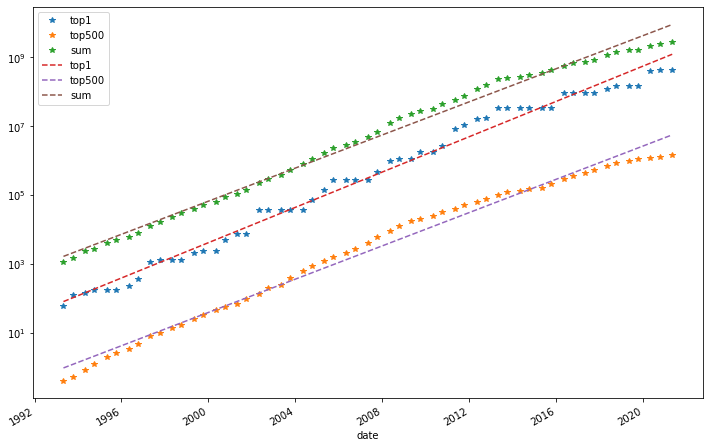

In [5]:
model = LinearRegression()
plt.figure(figsize=(12, 8))
bx = plt.subplot()
models = {}
predictions = {'date': df['date']}

for val in ['top1', 'top500', 'sum']:
    x = (df['date'] - df['date'][0]).dt.days.values.reshape(-1, 1)
    t = df[val].values.reshape(-1, 1)
    model.fit(x, np.log(t))
    y = np.exp(model.predict(x))
    predictions[val] = y.flatten()
    models[val] = (model.coef_, model.intercept_)
predictions = pd.DataFrame(predictions)

df.plot('date', ['top1', 'top500', 'sum'], ax=bx, logy=True, style='*')
predictions.plot('date', ['top1', 'top500', 'sum'], ax=bx, logy=True, style='--')

<H3>Результат предсказания</H3>

In [6]:
k, b = models['top1']
x = (pd.Timestamp('2025-06-01') - df['date'][0]).days
print(f'Согласно модели в 2025 году производительность компьютера #1 будет составлять {np.exp(k * x + b)[0][0]:.2} GFlop/s')

Согласно модели в 2025 году производительность компьютера #1 будет составлять 1.4e+10 GFlop/s


<H2>Задание 2</H2>

Оцените какой процент всего производимого на Земле электричества потребляют все компьютеры из top500 (на основании открытых данных top500.org)

Согласно https://yearbook.enerdata.net/electricity/world-electricity-production-statistics.html в 2020 году потребление электричества составило 26907  TWh. Осталось посчитать сколько электричества потребили топ500 суперкомпьютеров.

In [14]:
TOTAL_POWER_Wh = 2.6907e16
top500_06_20 = pd.read_excel('https://www.top500.org/files/green500/green500_top_202006.xlsx')
top500_11_20= pd.read_excel('https://www.top500.org/files/green500/green500_top_202011.xlsx')

In [15]:
power_kw_06_20 = top500_06_20['Power (kW)']
power_kw_11_20 = top500_11_20['Power (kW)']

In [16]:
power_kw_06_20 = power_kw_06_20.fillna(power_kw_06_20.median()).sum()
power_kw_11_20 = power_kw_11_20.fillna(power_kw_11_20.median()).sum()

In [17]:
days_Nov_Jun = (pd.Timestamp('2020-06-01') - pd.Timestamp('2019-11-01')).days
days_Jun_Nov = (pd.Timestamp('2020-11-01') - pd.Timestamp('2020-06-01')).days

In [18]:
total_kwh = power_kw_06_20 * days_Nov_Jun * 24 + power_kw_11_20 * days_Jun_Nov * 24
print(f'Топ 500 суперкомпьютеров суммарно потребляют {total_kwh:0.2f} kWh')

Топ 500 суперкомпьютеров суммарно потребляют 5247822434.40 kWh


In [24]:
print(f'Процент потребляемого суперкомпютерами эликтричества = {round(float(total_kwh * 1e5 / TOTAL_POWER_Wh), 4)}')

Процент потребляемого суперкомпютерами эликтричества = 0.0195
